In [ ]:
!pip install tsfresh

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import find_peaks
from scipy.stats import kurtosis
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import extract_relevant_features
from scipy.stats import skew, kurtosis

In [6]:
df = pd.read_csv('/content/drive/MyDrive/power_usage_2016_to_2020.csv')

df['date'] = pd.to_datetime(df['StartDate'])
df.drop(['notes', 'StartDate'], axis=1, inplace=True)
df['id'] = 1
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour
df['day_of_week'] = df['date'].dt.dayofweek
df['is_weekend'] = df['day_of_week'] >= 5
df['rolling_window'] = df['Value (kWh)'].rolling(6).mean()
df['kurtosis'] = df['Value (kWh)'].rolling(6).apply(lambda x: kurtosis(x))
df['peaks'] = df['Value (kWh)'].rolling(6).apply(lambda x: len(find_peaks(x)[0]))
df['expanding_window'] = df['Value (kWh)'].expanding(3).mean()
df['lag_-1'] = df['Value (kWh)'].shift(-1)
df['lag_1'] = df['Value (kWh)'].shift(1)

try:
    df.drop('lag_-1', axis=1, inplace=True)
except:
    pass
for i in range(1, 12):
    df['lag_' + str(i)] = df['Value (kWh)'].shift(i)
df.dropna(inplace=True)

df['year'] = df['year'].apply(lambda x: 2022 - x)


def is_dayoff(row):
    if row['month'] == 1 and row['day'] == 1:
        return 1
    # примерно рассчитаем День Мартина Лютера Кинга
    elif row['month'] == 1 and row['dayofweek'] == 0 and row['week'] == 8:
        return 1
    # примерно рассчитаем Президентский день
    elif row['month'] == 2 and row['dayofweek'] == 0 and row['week'] == 10:
        return 1
    # примерно рассчитаем День памяти
    elif row['month'] == 5 and row['dayofweek'] == 0 and row['week'] == 22:
        return 1
        # День Независимости
    elif row['month'] == 7 and row['day'] == 4:
        return 1
    # примерно рассчитаем День труда
    elif row['month'] == 9 and row['dayofweek'] == 0 and row['week'] == 37:
        return 1
        # примерно рассчитаем День Колумба
    elif row['month'] == 9 and row['dayofweek'] == 0 and row['week'] == 42:
        return 1
        # День Ветеранов
    elif row['month'] == 11 and row['day'] == 11:
        return 1
    # примерно рассчитаем День Благодарения
    elif row['month'] == 11 and row['dayofweek'] == 3 and row['week'] == 48:
        return 1
        # Рождество
    elif row['month'] == 12 and row['day'] == 25:
        return 1
    # Обычные выходные
    elif row['dayofweek'] >= 5:
        return 1
    else:
        return 0

In [7]:
df['season'] = np.where(df['month'].isin([3, 4, 5]), 'spring',
                        np.where(df['month'].isin([6, 7, 8]), 'summer',
                                 np.where(df['month'].isin([9, 10, 11]), 'autumn', 'winter')))
df['diff'] = df['Value (kWh)'].diff()
df['rolling_std'] = df['Value (kWh)'].rolling(window=6).std()
df['rolling_max'] = df['Value (kWh)'].rolling(window=6).max()
df['rolling_min'] = df['Value (kWh)'].rolling(window=6).min()
df['rolling_median'] = df['Value (kWh)'].rolling(window=6).median()
df['rolling_skew'] = df['Value (kWh)'].rolling(window=6).apply(lambda x: pd.Series(x).skew())
df['rolling_sum'] = df['Value (kWh)'].rolling(window=6).sum()
df['rolling_var'] = df['Value (kWh)'].rolling(window=6).var()
df['rolling_range'] = df['rolling_max'] - df['rolling_min']
df['rolling_iqr'] = df['Value (kWh)'].rolling(window=6).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

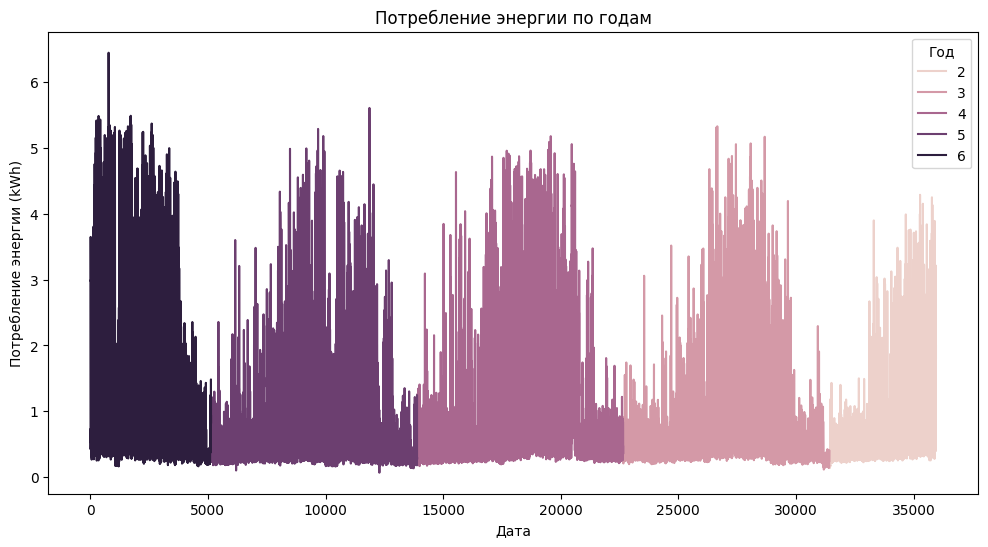

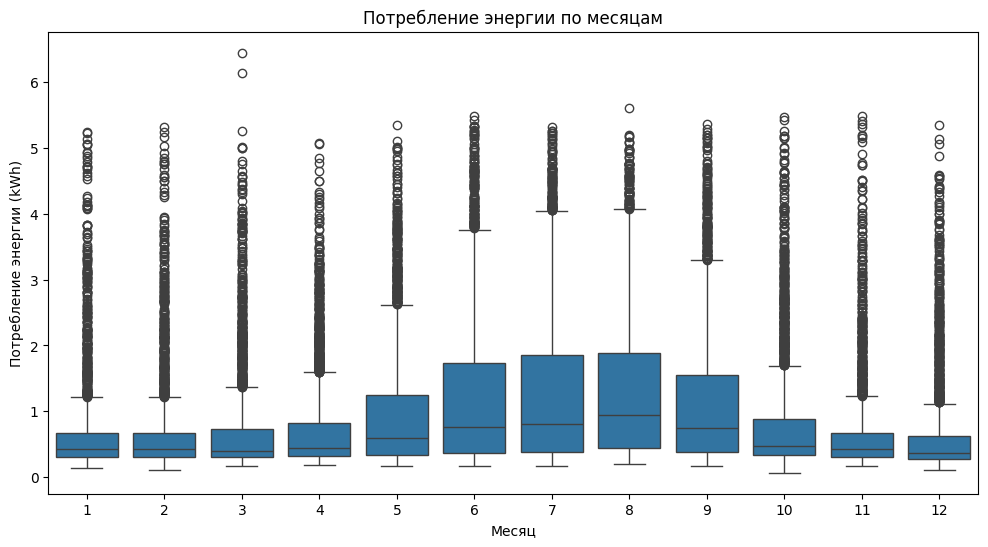

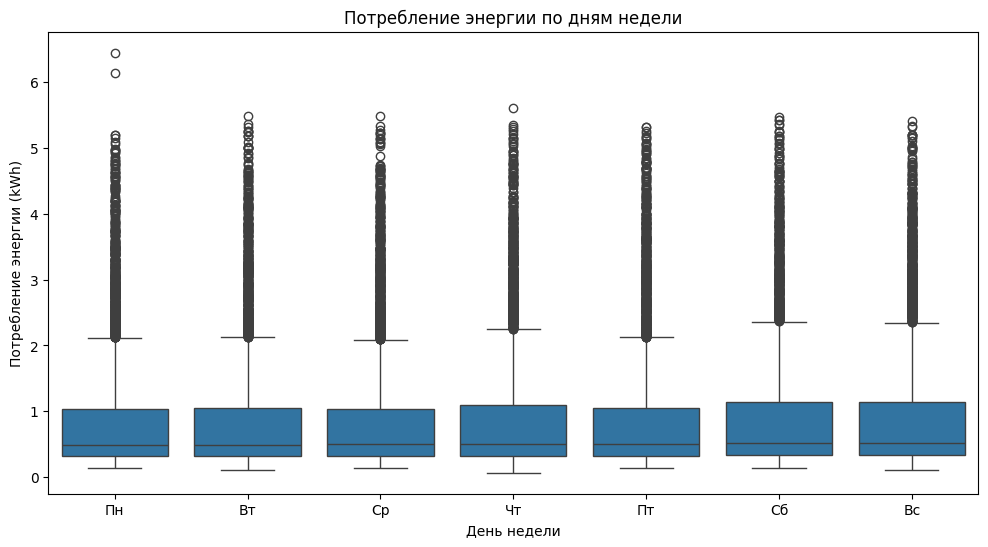

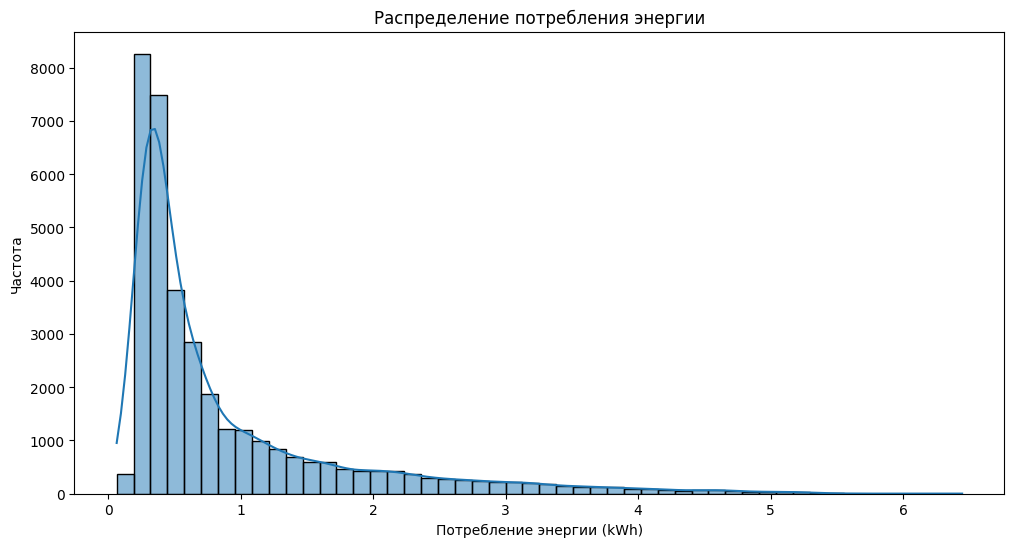

In [8]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x=df.index, y='Value (kWh)', hue='year')
plt.title('Потребление энергии по годам')
plt.xlabel('Дата')
plt.ylabel('Потребление энергии (kWh)')
plt.legend(title='Год')
plt.show()

# График потребления энергии по месяцам
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='month', y='Value (kWh)')
plt.title('Потребление энергии по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Потребление энергии (kWh)')
plt.show()

# График потребления энергии по дням недели
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='day_of_week', y='Value (kWh)')
plt.title('Потребление энергии по дням недели')
plt.xlabel('День недели')
plt.ylabel('Потребление энергии (kWh)')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.show()

# Гистограмма потребления энергии
plt.figure(figsize=(12, 6))
sns.histplot(df['Value (kWh)'], bins=50, kde=True)
plt.title('Распределение потребления энергии')
plt.xlabel('Потребление энергии (kWh)')
plt.ylabel('Частота')
plt.show()

In [5]:
# это дефолтное значение, оно слишком долго считается, поэтому для примера отсавим немного
default_fc_parameters = {
    "length": [],
    "entropy": [],
    "fft_coefficient": [{"coeff": 0, "attr": "real"}, {"coeff": 1, "attr": "real"}],
    "mean": [],
    "standard_deviation": [],
    "variance": [],
    "skewness": [],
    "kurtosis": [],
    "absolute_sum_of_changes": [],
    "longest_strike_below_mean": [],
    "longest_strike_above_mean": [],
    "count_above_mean": [],
    "count_below_mean": [],
    "last_location_of_maximum": [],
    "first_location_of_maximum": [],
    "last_location_of_minimum": [],
    "first_location_of_minimum": [],
    "benford_corpus": [],
    "c3": [],
    "cid_ce": [],
    "symmetry_looking": [],
    "large_standard_deviation": [{"r": 0.05}],
    "quantile": [{"q": 0.1}, {"q": 0.2}, {"q": 0.3}, {"q": 0.4}, {"q": 0.6}, {"q": 0.7}, {"q": 0.8}, {"q": 0.9}],
    "autocorrelation": [{"lag": 1}, {"lag": 2}, {"lag": 3}],
    "partial_autocorrelation": [],
    "number_cwt_peaks": [{"n": 1}],
    "number_peaks": [{"n": 1}, {"n": 5}, {"n": 10}],
    "binned_entropy": [],
    "index_mass_quantile": [],
    "augmented_dickey_fuller": [],
    "approximate_entropy": [{"m": 2, "r": 0.1}],
    "permutation_entropy": [{"tau": 1, "dimension": 3}, {"tau": 1, "dimension": 4}, {"tau": 1, "dimension": 5}, {"tau": 1, "dimension": 6}, {"tau": 1, "dimension": 7}],
    "sample_entropy": [],
    "linear_trend": [{"attr": "pvalue"}, {"attr": "rvalue"}, {"attr": "intercept"}, {"attr": "slope"}, {"attr": "stderr"}],
    "agg_linear_trend": [{"attr": "rvalue", "chunk_len": 5, "f_agg": "mean"}, {"attr": "rvalue", "chunk_len": 5, "f_agg": "min"}, {"attr": "rvalue", "chunk_len": 5, "f_agg": "max"}, {"attr": "rvalue", "chunk_len": 10, "f_agg": "mean"}, {"attr": "rvalue", "chunk_len": 10, "f_agg": "min"}, {"attr": "rvalue", "chunk_len": 10, "f_agg": "max"}],
    "cwt_coefficients": [{"coeff": 0, "w": 2, "widths": (2, 5, 10, 20)}, {"coeff": 0, "w": 5, "widths": (2, 5, 10, 20)}, {"coeff": 0, "w": 10, "widths": (2, 5, 10, 20)}, {"coeff": 0, "w": 20, "widths": (2, 5, 10, 20)}],
    "ar_coefficient": [{"coeff": 0, "k": 10}, {"coeff": 1, "k": 10}, {"coeff": 2, "k": 10}, {"coeff": 3, "k": 10}],
    "change_quantiles": [{"ql": 0.0, "qh": 1.0, "isabs": False, "f_agg": "mean"}, {"ql": 0.0, "qh": 1.0, "isabs": False, "f_agg": "var"}],
    "friedrich_coefficients": [{"coeff": 0, "m": 3, "r": 30}, {"coeff": 1, "m": 3, "r": 30}, {"coeff": 2, "m": 3, "r": 30}, {"coeff": 3, "m": 3, "r": 30}],
    "max_langevin_fixed_point": [{"m": 3, "r": 30}],
    "linear_trend_timewise": [{"attr": "pvalue"}, {"attr": "rvalue"}, {"attr": "intercept"}, {"attr": "slope"}, {"attr": "stderr"}],
    "agg_autocorrelation": [{"f_agg": "mean", "maxlag": 40}, {"f_agg": "median", "maxlag": 40}, {"f_agg": "var", "maxlag": 40}],
    "spkt_welch_density": [{"coeff": 2}, {"coeff": 5}, {"coeff": 8}],
    "ratio_beyond_r_sigma": [{"r": 1}, {"r": 2}, {"r": 3}],
    "ratio_value_number_to_time_series_length": [],
    "range_count": [{"min": -1.0, "max": 1.0}],
    "symmetry_looking": [{"r": 0.05}, {"r": 0.1}, {"r": 0.2}, {"r": 0.3}, {"r": 0.4}, {"r": 0.5}],
    "time_reversal_asymmetry_statistic": [{"lag": 1}, {"lag": 2}, {"lag": 3}],
    "c3": [{"lag": 1}, {"lag": 2}, {"lag": 3}],
    "cid_ce": [{"normalize": True}, {"normalize": False}],
    "standard_deviation": [{"normalize": True}],
    "variance": [{"normalize": True}],
    "skewness": [{"normalize": True}],
    "kurtosis": [{"normalize": True}],
    "absolute_sum_of_changes": [{"normalize": True}],
    "longest_strike_below_mean": [{"normalize": True}],
    "longest_strike_above_mean": [{"normalize": True}],
    "count_above_mean": [{"normalize": True}],
    "count_below_mean": [{"normalize": True}],
    "last_location_of_maximum": [{"normalize": True}],
    "first_location_of_maximum": [{"normalize": True}],
    "last_location_of_minimum": [{"normalize": True}],
    "first_location_of_minimum": [{"normalize": True}],
    "benford_corpus": [{"base": 10}],
    "c3": [{"lag": 1}, {"lag": 2}, {"lag": 3}],
    "cid_ce": [{"normalize": True}, {"normalize": False}],
    "symmetry_looking": [{"r": 0.05}, {"r": 0.1}, {"r": 0.2}, {"r": 0.3}, {"r": 0.4}, {"r": 0.5}],
    "large_standard_deviation": [{"r": 0.05}],
    "quantile": [{"q": 0.1}, {"q": 0.2}, {"q": 0.3}, {"q": 0.4}, {"q": 0.6}, {"q": 0.7}, {"q": 0.8}, {"q": 0.9}],
    "autocorrelation": [{"lag": 1}, {"lag": 2}, {"lag": 3}],
    "partial_autocorrelation": [{"lag": 1}, {"lag": 2}, {"lag": 3}],
    "number_cwt_peaks": [{"n": 1}],
    "number_peaks": [{"n": 1}, {"n": 5}, {"n": 10}],
    "binned_entropy": [{"max_bins": 10}],
    "index_mass_quantile": [{"q": 0.1}, {"q": 0.2}, {"q": 0.3}, {"q": 0.4}, {"q": 0.6}, {"q": 0.7}, {"q": 0.8}, {"q": 0.9}],
    "augmented_dickey_fuller": [{"attr": "teststat"}, {"attr": "pvalue"}, {"attr": "usedlag"}, {"attr": "nobs"}],
    "approximate_entropy": [{"m": 2, "r": 0.1}],
    "permutation_entropy": [{"tau": 1, "dimension": 3}, {"tau": 1, "dimension": 4}, {"tau": 1, "dimension": 5}, {"tau": 1, "dimension": 6}, {"tau": 1, "dimension": 7}],
    "sample_entropy": [],
    "linear_trend": [{"attr": "pvalue"}, {"attr": "rvalue"}, {"attr": "intercept"}, {"attr": "slope"}, {"attr": "stderr"}],
    "agg_linear_trend": [{"attr": "rvalue", "chunk_len": 5, "f_agg": "mean"}, {"attr": "rvalue", "chunk_len": 5, "f_agg": "min"}, {"attr": "rvalue", "chunk_len": 5, "f_agg": "max"}, {"attr": "rvalue", "chunk_len": 10, "f_agg": "mean"}, {"attr": "rvalue", "chunk_len": 10, "f_agg": "min"}, {"attr": "rvalue", "chunk_len": 10, "f_agg": "max"}],
    "cwt_coefficients": [{"coeff": 0, "w": 2, "widths": (2, 5, 10, 20)}, {"coeff": 0, "w": 5, "widths": (2, 5, 10, 20)}, {"coeff": 0, "w": 10, "widths": (2, 5, 10, 20)}, {"coeff": 0, "w": 20, "widths": (2, 5, 10, 20)}],
    "ar_coefficient": [{"coeff": 0, "k": 10}, {"coeff": 1, "k": 10}, {"coeff": 2, "k": 10}, {"coeff": 3, "k": 10}],
    "change_quantiles": [{"ql": 0.0, "qh": 1.0, "isabs": False, "f_agg": "mean"}, {"ql": 0.0, "qh": 1.0, "isabs": False, "f_agg": "var"}],
    "friedrich_coefficients": [{"coeff": 0, "m": 3, "r": 30}, {"coeff": 1, "m": 3, "r": 30}, {"coeff": 2, "m": 3, "r": 30}, {"coeff": 3, "m": 3, "r": 30}],
    "max_langevin_fixed_point": [{"m": 3, "r": 30}],
    "linear_trend_timewise": [{"attr": "pvalue"}, {"attr": "rvalue"}, {"attr": "intercept"}, {"attr": "slope"}, {"attr": "stderr"}],
    "agg_autocorrelation": [{"f_agg": "mean", "maxlag": 40}, {"f_agg": "median", "maxlag": 40}, {"f_agg": "var", "maxlag": 40}],
    "spkt_welch_density": [{"coeff": 2}, {"coeff": 5}, {"coeff": 8}],
    "ratio_beyond_r_sigma": [{"r": 1}, {"r": 2}, {"r": 3}],
    "ratio_value_number_to_time_series_length": [],
    "range_count": [{"min": -1.0, "max": 1.0}],
    "symmetry_looking": [{"r": 0.05}, {"r": 0.1}, {"r": 0.2}, {"r": 0.3}, {"r": 0.4}, {"r": 0.5}],
    "time_reversal_asymmetry_statistic": [{"lag": 1}, {"lag": 2}, {"lag": 3}],
    "c3": [{"lag": 1}, {"lag": 2}, {"lag": 3}],
    "cid_ce": [{"normalize": True}, {"normalize": False}],
}

default_fc_parameters = {
    "length": [],
    "fft_coefficient": [{"coeff": 0, "attr": "real"}, {"coeff": 1, "attr": "real"}],
    "mean": [],
}

In [57]:
df = pd.read_csv('/content/drive/MyDrive/power_usage_2016_to_2020.csv')
window_size = 1


df['date'] = pd.to_datetime(df['StartDate'])
df['id'] = 1
df['hour'] = df['date'].dt.hour
df['window_id'] = (df['date'].dt.to_period('H').astype(int) // window_size).astype(int)

df.drop(['notes', 'StartDate'], axis=1, inplace=True)
df.dropna(inplace=True)
extracted_features = extract_features(df, column_id="window_id", column_sort="date",  default_fc_parameters=default_fc_parameters)
impute(extracted_features)
extracted_features

<ipython-input-57-19e09a35f0d5>:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['window_id'] = (df['date'].dt.to_period('H').astype(int) // window_size).astype(int)
Feature Extraction: 100%|██████████| 143808/143808 [00:32<00:00, 4409.07it/s]
/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['Value (kWh)__fft_coefficient__attr_"real"__coeff_1'
 'day_of_week__fft_coefficient__attr_"real"__coeff_1'
 'id__fft_coefficient__attr_"real"__coeff_1'
 'hour__fft_coefficient__attr_"real"__coeff_1'] did not have any finite values. Filling with zeros.
  warnings.warn(


,Value (kWh)__length,"Value (kWh)__fft_coefficient__attr_""real""__coeff_0","Value (kWh)__fft_coefficient__attr_""real""__coeff_1",Value (kWh)__mean,day_of_week__length,"day_of_week__fft_coefficient__attr_""real""__coeff_0","day_of_week__fft_coefficient__attr_""real""__coeff_1",day_of_week__mean,id__length,"id__fft_coefficient__attr_""real""__coeff_0","id__fft_coefficient__attr_""real""__coeff_1",id__mean,hour__length,"hour__fft_coefficient__attr_""real""__coeff_0","hour__fft_coefficient__attr_""real""__coeff_1",hour__mean
403344,1.0,1.057,0.0,1.057,1.0,2.0,0.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
403345,1.0,1.171,0.0,1.171,1.0,2.0,0.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
403346,1.0,0.560,0.0,0.560,1.0,2.0,0.0,2.0,1.0,1.0,0.0,1.0,1.0,2.0,0.0,2.0
403347,1.0,0.828,0.0,0.828,1.0,2.0,0.0,2.0,1.0,1.0,0.0,1.0,1.0,3.0,0.0,3.0
403348,1.0,0.932,0.0,0.932,1.0,2.0,0.0,2.0,1.0,1.0,0.0,1.0,1.0,4.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446467,1.0,2.311,0.0,2.311,1.0,6.0,0.0,6.0,1.0,1.0,0.0,1.0,1.0,19.0,0.0,19.0
446468,1.0,1.958,0.0,1.958,1.0,6.0,0.0,6.0,1.0,1.0,0.0,1.0,1.0,20.0,0.0,20.0
446469,1.0,2.274,0.0,2.274,1.0,6.0,0.0,6.0,1.0,1.0,0.0,1.0,1.0,21.0,0.0,21.0
446470,1.0,1.617,0.0,1.617,1.0,6.0,0.0,6.0,1.0,1.0,0.0,1.0,1.0,22.0,0.0,22.0


In [60]:
extracted_features.index = df.index
df_with_features = pd.concat([df, extracted_features], axis=1)
df_with_features.dropna(inplace=True)
df_with_features

,Value (kWh),day_of_week,date,id,hour,window_id,Value (kWh)__length,"Value (kWh)__fft_coefficient__attr_""real""__coeff_0","Value (kWh)__fft_coefficient__attr_""real""__coeff_1",Value (kWh)__mean,...,"day_of_week__fft_coefficient__attr_""real""__coeff_1",day_of_week__mean,id__length,"id__fft_coefficient__attr_""real""__coeff_0","id__fft_coefficient__attr_""real""__coeff_1",id__mean,hour__length,"hour__fft_coefficient__attr_""real""__coeff_0","hour__fft_coefficient__attr_""real""__coeff_1",hour__mean
0,1.057,2,2016-01-06 00:00:00,1,0,403344,1.0,1.057,0.0,1.057,...,0.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
1,1.171,2,2016-01-06 01:00:00,1,1,403345,1.0,1.171,0.0,1.171,...,0.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
2,0.560,2,2016-01-06 02:00:00,1,2,403346,1.0,0.560,0.0,0.560,...,0.0,2.0,1.0,1.0,0.0,1.0,1.0,2.0,0.0,2.0
3,0.828,2,2016-01-06 03:00:00,1,3,403347,1.0,0.828,0.0,0.828,...,0.0,2.0,1.0,1.0,0.0,1.0,1.0,3.0,0.0,3.0
4,0.932,2,2016-01-06 04:00:00,1,4,403348,1.0,0.932,0.0,0.932,...,0.0,2.0,1.0,1.0,0.0,1.0,1.0,4.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35947,1.307,1,2020-07-07 19:00:00,1,19,442819,1.0,2.311,0.0,2.311,...,0.0,6.0,1.0,1.0,0.0,1.0,1.0,19.0,0.0,19.0
35948,2.872,1,2020-07-07 20:00:00,1,20,442820,1.0,1.958,0.0,1.958,...,0.0,6.0,1.0,1.0,0.0,1.0,1.0,20.0,0.0,20.0
35949,2.138,1,2020-07-07 21:00:00,1,21,442821,1.0,2.274,0.0,2.274,...,0.0,6.0,1.0,1.0,0.0,1.0,1.0,21.0,0.0,21.0
35950,2.199,1,2020-07-07 22:00:00,1,22,442822,1.0,1.617,0.0,1.617,...,0.0,6.0,1.0,1.0,0.0,1.0,1.0,22.0,0.0,22.0


In [61]:
df = pd.read_csv('/content/drive/MyDrive/power_usage_2016_to_2020.csv')

df['date'] = pd.to_datetime(df['StartDate'])
df['id'] = 1
df['hour'] = df['date'].dt.hour

# Вычислите асимметрию и эксцесс
skewness = skew(df['Value (kWh)'])
kurt = kurtosis(df['Value (kWh)'])

print(f'Асимметрия: {skewness}')
print(f'Эксцесс: {kurt}')

Асимметрия: 2.1284142539189737
Эксцесс: 4.532479312377308
